###CPU

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# =====================================================
# 1. CONFIGURACIÓN DE ARCHIVOS DE ENTRADA Y SALIDA
# =====================================================
# input_video  : video original en color
# output_video : video resultante en escala de grises
input_video = "video_input.mp4"
output_video = "output_cpu_grayscale.mp4"

# =====================================================
# 2. LECTURA DEL VIDEO Y PROPIEDADES
# =====================================================
# Se abre el video y se leen sus propiedades básicas
cap = cv2.VideoCapture(input_video)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # ancho del frame
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # alto del frame
fps    = int(cap.get(cv2.CAP_PROP_FPS))           # frames por segundo

# =====================================================
# 3. DEFINICIÓN DEL VIDEO DE SALIDA
# =====================================================
# Se crea el escritor del nuevo video en escala de grises
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=False)

# =====================================================
# 4. INICIO MEDICIÓN DE TIEMPO
# =====================================================
start = time.time()

# Variables para guardar un frame de ejemplo
frame_original = None
frame_gray = None
frame_count = 0

# =====================================================
# 5. PROCESAMIENTO DEL VIDEO (CPU)
# =====================================================
# Cada frame se convierte a escala de grises usando
# operaciones vectorizadas (CPU, no paralela)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Conversión a escala de grises (CPU vectorizado)
    gray = (
        0.114 * frame[:,:,0] +
        0.587 * frame[:,:,1] +
        0.299 * frame[:,:,2]
    ).astype(np.uint8)

    # Guardar frame procesado en el nuevo video
    out.write(gray)

    # Guardar solo el primer frame para visualización
    if frame_count == 500:
      frame_original = frame.copy()
      frame_gray = gray.copy()

    frame_count += 1

# =====================================================
# 6. FIN DE MEDICIÓN DE TIEMPO Y LIBERACIÓN DE RECURSOS
# =====================================================
end = time.time()

cap.release()
out.release()

# =====================================================
# 7. RESULTADOS
# =====================================================
print(f"Tiempo total CPU: {end - start:.4f} segundos")
print("✅ Video CPU generado correctamente")


Tiempo total CPU: 30.5879 segundos
✅ Video CPU generado correctamente


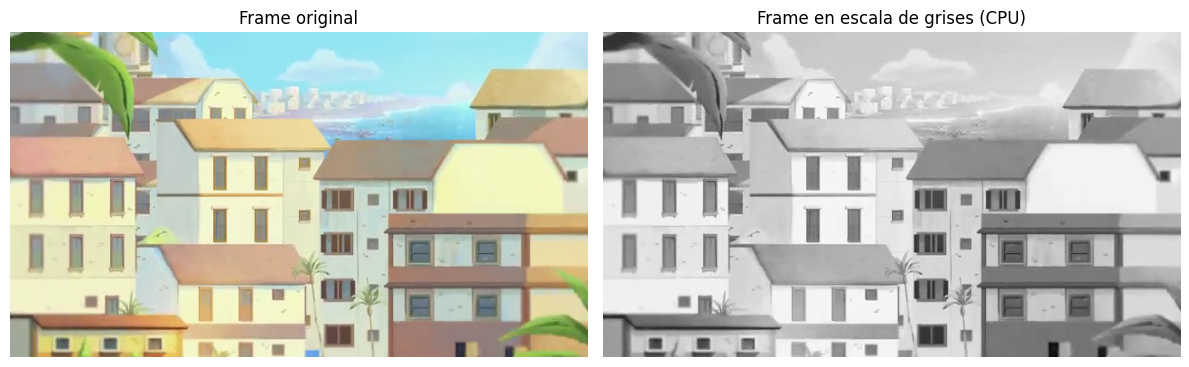

In [12]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(12,5))

# Frame original (color)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(frame_original, cv2.COLOR_BGR2RGB))
plt.title("Frame original")
plt.axis("off")

# Frame procesado (escala de grises)
plt.subplot(1,2,2)
plt.imshow(frame_gray, cmap="gray")
plt.title("Frame en escala de grises (CPU)")
plt.axis("off")

plt.tight_layout()
plt.show()


##GPU

In [1]:
!pip install cupy-cuda12x opencv-python


In [2]:
import cupy as cp

print("GPU detectada:")
print(cp.cuda.runtime.getDeviceProperties(0)["name"])


GPU detectada:
b'Tesla T4'


In [5]:
import cv2
import cupy as cp
import numpy as np
import time

# =====================================================
# 1. CONFIGURACIÓN DE ARCHIVOS DE ENTRADA Y SALIDA
# =====================================================
input_video = "video_input.mp4"
output_video = "output_cuda_grayscale.mp4"

# =====================================================
# 2. KERNEL CUDA PERSONALIZADO
# =====================================================
kernel_code = '''
extern "C"
__global__ void rgb_to_grayscale(const unsigned char *input, unsigned char *output, int rows, int cols) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < cols && y < rows) {
        int idx = (y * cols + x) * 3;
        int out_idx = y * cols + x;

        unsigned char b = input[idx];
        unsigned char g = input[idx + 1];
        unsigned char r = input[idx + 2];

        output[out_idx] = (unsigned char)(0.114f * b + 0.587f * g + 0.299f * r);
    }
}
'''

# Compilar kernel CUDA
module = cp.RawModule(code=kernel_code)
rgb_to_grayscale = module.get_function('rgb_to_grayscale')

# =====================================================
# 3. LECTURA DEL VIDEO Y PROPIEDADES
# =====================================================
cap = cv2.VideoCapture(input_video)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 Video: {width}x{height} @ {fps}fps ({total_frames} frames)")

# =====================================================
# 4. DEFINICIÓN DEL VIDEO DE SALIDA
# =====================================================
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=False)

# =====================================================
# 5. CONFIGURACIÓN CUDA
# =====================================================
# Bloques y threads para la GPU
block_size = (16, 16)  # threads por bloque
grid_size = (
    (width + block_size[0] - 1) // block_size[0],
    (height + block_size[1] - 1) // block_size[1]
)

print(f"🔧 Configuración CUDA: {grid_size} bloques, {block_size} threads/bloque")

# =====================================================
# 6. INICIO MEDICIÓN DE TIEMPO
# =====================================================
start = time.time()

frame_count = 0

# =====================================================
# 7. PROCESAMIENTO DEL VIDEO (GPU - KERNEL CUDA)
# =====================================================
print("⏳ Procesando video en GPU...\n")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Transferir frame a GPU (BGR)
    frame_gpu = cp.asarray(frame)

    # Allocar memoria en GPU para output
    gray_gpu = cp.zeros((height, width), dtype=cp.uint8)

    # Ejecutar kernel CUDA personalizado
    rgb_to_grayscale(
        grid=grid_size,
        block=block_size,
        args=(frame_gpu.data.ptr, gray_gpu.data.ptr, cp.int32(height), cp.int32(width))
    )

    # Sincronizar GPU para asegurar que el kernel terminó
    cp.cuda.Stream.null.synchronize()

    # Transferir resultado a CPU solo para escribir en video
    gray = cp.asnumpy(gray_gpu)

    # Guardar frame procesado en el nuevo video
    out.write(gray)

    frame_count += 1

    if frame_count % 100 == 0:
        print(f"  ✓ {frame_count}/{total_frames} frames procesados")

# =====================================================
# 8. FIN DE MEDICIÓN DE TIEMPO Y LIBERACIÓN DE RECURSOS
# =====================================================
end = time.time()

cap.release()
out.release()

# =====================================================
# 9. RESULTADOS
# =====================================================
tiempo_total = end - start
fps_promedio = frame_count / tiempo_total

print(f"\n{'='*50}")
print(f"⏱️  Tiempo total GPU (CUDA Kernel): {tiempo_total:.4f} segundos")
print(f"📊 Frames procesados: {frame_count}")
print(f"📈 FPS promedio: {fps_promedio:.2f} fps")
print(f"✅ Video GPU generado: {output_video}")
print(f"{'='*50}")

📹 Video: 640x360 @ 24fps (6121 frames)
🔧 Configuración CUDA: (40, 23) bloques, (16, 16) threads/bloque
⏳ Procesando video en GPU...

  ✓ 100/6121 frames procesados
  ✓ 200/6121 frames procesados
  ✓ 300/6121 frames procesados
  ✓ 400/6121 frames procesados
  ✓ 500/6121 frames procesados
  ✓ 600/6121 frames procesados
  ✓ 700/6121 frames procesados
  ✓ 800/6121 frames procesados
  ✓ 900/6121 frames procesados
  ✓ 1000/6121 frames procesados
  ✓ 1100/6121 frames procesados
  ✓ 1200/6121 frames procesados
  ✓ 1300/6121 frames procesados
  ✓ 1400/6121 frames procesados
  ✓ 1500/6121 frames procesados
  ✓ 1600/6121 frames procesados
  ✓ 1700/6121 frames procesados
  ✓ 1800/6121 frames procesados
  ✓ 1900/6121 frames procesados
  ✓ 2000/6121 frames procesados
  ✓ 2100/6121 frames procesados
  ✓ 2200/6121 frames procesados
  ✓ 2300/6121 frames procesados
  ✓ 2400/6121 frames procesados
  ✓ 2500/6121 frames procesados
  ✓ 2600/6121 frames procesados
  ✓ 2700/6121 frames procesados
  ✓ 2800/612

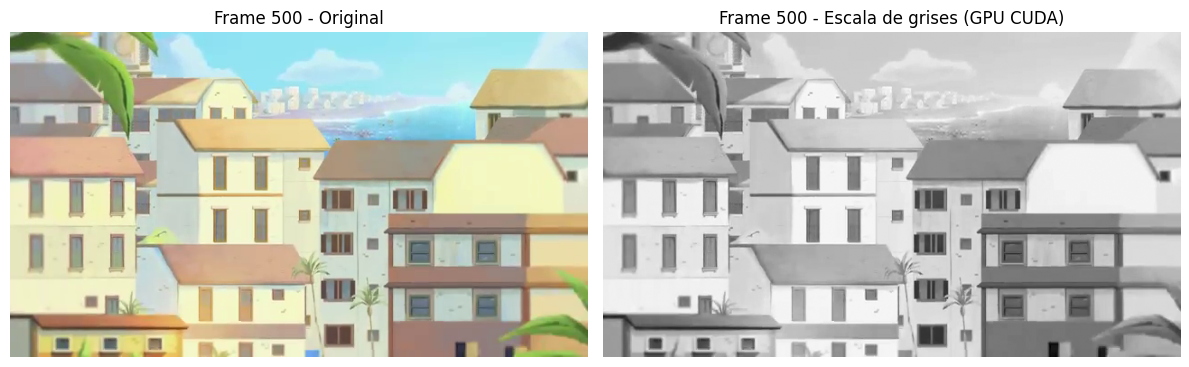

In [6]:
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# Ir directamente al frame 500
# -----------------------------------------------------
cap_test = cv2.VideoCapture(input_video)
cap_test.set(cv2.CAP_PROP_POS_FRAMES, 500)

ret, frame = cap_test.read()
cap_test.release()

if not ret:
    raise ValueError("No se pudo leer el frame 500")

# -----------------------------------------------------
# Procesar frame 500 en GPU (mismo kernel)
# -----------------------------------------------------
frame_gpu = cp.asarray(frame)
gray_gpu = cp.zeros((height, width), dtype=cp.uint8)

rgb_to_grayscale(
    grid=grid_size,
    block=block_size,
    args=(frame_gpu.data.ptr, gray_gpu.data.ptr, cp.int32(height), cp.int32(width))
)

cp.cuda.Stream.null.synchronize()
gray = cp.asnumpy(gray_gpu)

# -----------------------------------------------------
# Mostrar comparación
# -----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Frame 500 - Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gray, cmap="gray")
plt.title("Frame 500 - Escala de grises (GPU CUDA)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
import sys
import platform
import cv2
import numpy as np
import cupy as cp

print("="*60)
print("🔧 ENTORNO DE EJECUCIÓN")
print("="*60)

# Información del sistema
print(f"Sistema operativo : {platform.system()} {platform.release()}")
print(f"Arquitectura       : {platform.machine()}")
print(f"Procesador         : {platform.processor()}")
print()

# Python
print(f"Python versión     : {sys.version.split()[0]}")
print()

# Librerías principales
print("📦 LIBRERÍAS")
print(f"OpenCV versión     : {cv2.__version__}")
print(f"NumPy versión      : {np.__version__}")
print(f"CuPy versión       : {cp.__version__}")
print()

# GPU y CUDA
print("🖥️ GPU / CUDA")
print(f"GPU detectada      : {cp.cuda.runtime.getDeviceProperties(0)['name']}")
print(f"CUDA Runtime ver.  : {cp.cuda.runtime.runtimeGetVersion()}")
print(f"CUDA Driver ver.   : {cp.cuda.runtime.driverGetVersion()}")

print("="*60)


🔧 ENTORNO DE EJECUCIÓN
Sistema operativo : Linux 6.6.105+
Arquitectura       : x86_64
Procesador         : x86_64

Python versión     : 3.12.12

📦 LIBRERÍAS
OpenCV versión     : 4.12.0
NumPy versión      : 2.0.2
CuPy versión       : 13.6.0

🖥️ GPU / CUDA
GPU detectada      : b'Tesla T4'
CUDA Runtime ver.  : 12090
CUDA Driver ver.   : 12040


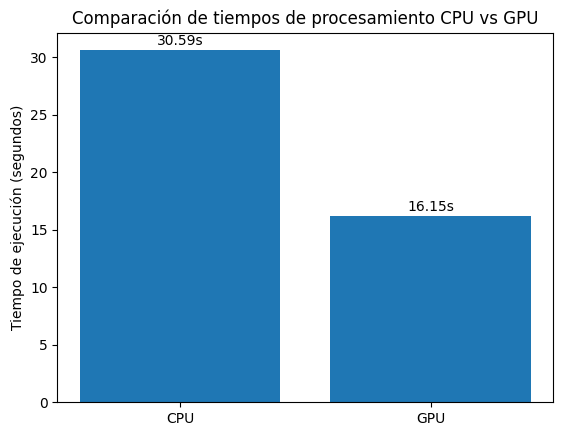

In [8]:
import matplotlib.pyplot as plt

# Tiempos medidos (segundos)
tiempos = {
    "CPU": 30.5879,
    "GPU": 16.1489
}

# Datos para la gráfica
labels = list(tiempos.keys())
values = list(tiempos.values())

# Crear la gráfica
plt.figure()
plt.bar(labels, values)

# Etiquetas y título
plt.ylabel("Tiempo de ejecución (segundos)")
plt.title("Comparación de tiempos de procesamiento CPU vs GPU")

# Mostrar valores sobre cada barra
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.2f}s", ha='center')

# Mostrar gráfica
plt.show()
